In [1]:
# standard lib imports
import os.path
import zipfile
import json
from functools import wraps

# 3rd party imports
import pandas as pd
from scipy.stats import entropy 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
%matplotlib inline

# project imports
from plotter import ReportPlotter
from functions import get_survey_year, get_fraction_of_answers
import log_config
logger = log_config.get_configured_logger('stdout')

# constants
IMG_PTH = os.path.join(os.getcwd(), './data/output')
plotter = ReportPlotter(IMG_PTH)

/home/kornel/Dokumente/Programmieren/udacity_ds/proj1/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Getting an overview of data

In [2]:
# read survey data of 2019 and display overview of data
data_19 = get_survey_year(2019)
data_19.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelorâs degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelorâs degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelorâs degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [3]:
# get overview of all parameters and the number of datapoints
data_19.columns, data_19.shape[0]

(Index(['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource',
        'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor',
        'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode',
        'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney',
        'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz',
        'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc',
        'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan',
        'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev',
        'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat',
        'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith',
        'DatabaseDesireNextYear', 'PlatformWorkedWith',
        'PlatformDesireNextYear', 'WebFrameWorkedWith',
        'WebFrameDesireNextYear', 'MiscTechWorkedWith',
        'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
        'BlockchainOrg', 'BlockchainIs

# How happy are people with their job?

In [4]:
# drop all rows (datapoints) with no values in the variable of interest
data_19 = data_19.dropna(subset=['JobSat'])
# make sure that only people were surveyed about JobStatisfaction which are currently working
set(data_19['Employment'].values)

{'Employed full-time',
 'Employed part-time',
 'Independent contractor, freelancer, or self-employed',
 nan}

In [5]:
# change nominal values to intergers in order to represent ordinal scale
data_19['JobSat'].replace({
    'Very dissatisfied': 1,
    'Slightly dissatisfied': 2,
    'Neither satisfied nor dissatisfied': 3,
    'Slightly satisfied': 4,
    'Very satisfied': 5
}, inplace=True)

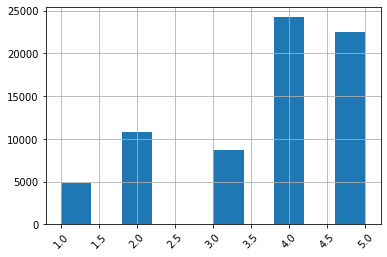

In [6]:
# create histogram
data_19['JobSat'].hist(xrot=45)

In [7]:
# some descriptive statistics about job-happiness (careful with the interpretation though as this is a ordinal parameter)
data_19['JobSat'].describe()

count    70988.000000
mean         3.685257
std          1.249682
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: JobSat, dtype: float64

In [8]:
# fraction of people dissatisfied with their current job situation
sum(data_19['JobSat'].isin([1, 2])) / float(data_19.shape[0])

0.21988223361694934

The data shows that great majority of people is happy in their current job situation (slightly satisfied or very satisfied). Only 22% state that they are unsatisfied with their job-situation.

# Is there a connection between Satisfaction in the Job and loyalty towards their job?

In [9]:
# For answering this question me must filter also all self-employed and freelancers
data_19_hired = data_19[data_19.Employment.isin(['Employed full-time', 'Employed part-time'])]
data_19_hired.groupby('JobSeek').apply(lambda x: x['JobSat'].describe()).sort_values('mean')

JobSat,count,mean,std,min,25%,50%,75%,max
JobSeek,,,,,,,,
I am actively looking for a job,7001.0,2.613055,1.268338,1.0,2.0,2.0,4.0,5.0
"Iâm not actively looking, but I am open to new opportunities",38435.0,3.566567,1.167218,1.0,3.0,4.0,4.0,5.0
I am not interested in new job opportunities,18376.0,4.337016,1.029837,1.0,4.0,5.0,5.0,5.0


This table shows a very strong connection between the job satisfaction and the willingness of people getting a new job.

In [10]:
data_19_hired.groupby('LastHireDate').apply(lambda x: x['JobSat'].describe()).sort_values('mean')

JobSat,count,mean,std,min,25%,50%,75%,max
LastHireDate,,,,,,,,
I've never had a job,176.0,3.539773,1.286683,1.0,3.0,4.0,5.0,5.0
More than 4 years ago,13276.0,3.617505,1.264366,1.0,3.0,4.0,5.0,5.0
3-4 years ago,10327.0,3.625545,1.248628,1.0,3.0,4.0,5.0,5.0
1-2 years ago,18459.0,3.636708,1.244334,1.0,3.0,4.0,5.0,5.0
Less than a year ago,20925.0,3.792258,1.234499,1.0,3.0,4.0,5.0,5.0
NA - I am an independent contractor or self employed,422.0,3.936019,1.266480,1.0,3.0,4.0,5.0,5.0


Even though we filtered only for participants which are currently hired, we have some answers that state that they have had never a job or that they are self-employed and are therefor contradicting. These answers should be neglected.
The remaining results are somewhat surprising: The Job-Satisfaction seems with a mean of 3.79 highest in the first year drop significantly towards the second (3.63) and the decrease very slightly with the time people stay at their job.

This seems to be at first glance contradicting to the first result, that unsatisfied employees look actively for a new job and therefor should not be sticking to their position when theyend up in a position or working environment with which they are not comfortable with. So let's have a look if there are differences between the answers compared to 

In [11]:
def reindex_timehired(df):
    """
    reindex aggregated DataFrame based on index-values representing 'LastHireDate'-column
    """
    return df.reindex(['Less than a year ago', '1-2 years ago', '3-4 years ago', 'More than 4 years ago'])

data_19_hired = data_19_hired[ ~data_19_hired['LastHireDate'].isin(
    ["I've never had a job", "NA - I am an independent contractor or self employed"])]

comp_df = pd.DataFrame({
    'satisfied': get_fraction_of_answers(
        data_19_hired[data_19_hired['JobSat'].isin([4, 5])], col='LastHireDate'),
    'dissatisfied': get_fraction_of_answers(
        data_19_hired[data_19_hired['JobSat'].isin([1, 2])], col='LastHireDate')
})
comp_df['diff'] = comp_df['satisfied'] - comp_df['dissatisfied']
comp_df = reindex_timehired(comp_df)
comp_df.style.bar(subset=['diff'], align='mid', color=['#d65f5f', '#5fba7d'])

/home/kornel/Dokumente/Programmieren/udacity_ds/proj1/functions.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=[col], inplace=True)


,satisfied,dissatisfied,diff
Less than a year ago,0.348029,0.285582,0.062448
1-2 years ago,0.287592,0.304730,-0.017138
3-4 years ago,0.160170,0.175979,-0.015809
More than 4 years ago,0.204209,0.233710,-0.029501


This graph shows a rather surprising result: The fractions of satisfied vs dissatisfied employees are not evenly distributed. But while people which are dissatisfied with their job claim to look for other opportunities and therefor would not to be expected to be very long at their current position, it seems to be the other way round:
Employees who are dissatisfied are relatively longer in their current job compared to satisfied employees.

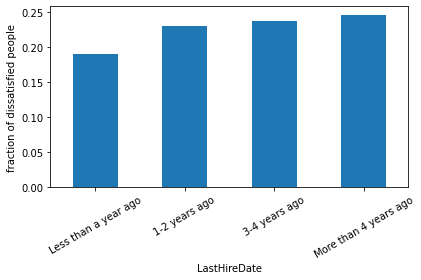

In [12]:

# calculate fraction of people with low job-satisfaction (1 or 2) grouped by time they are hired
fraction_dissatisfied = data_19_hired.groupby('LastHireDate').apply(
    lambda x: x['JobSat'].isin([1, 2]).sum() / x['JobSat'].count()
)
fraction_dissatisfied = reindex_timehired(fraction_dissatisfied)
ax = fraction_dissatisfied.plot.bar(rot=30)
ax.set_ylabel("fraction of dissatisfied people")

fig = ax.get_figure()
plt.tight_layout()
fig.savefig(os.path.join(IMG_PTH, 'satisfied_lasthired2.png'), format='png', dpi=300)

The second graph shows the fraction of dissatisfied people compared to all people within the same hireing-time. It shows that the dissatisfaction seems to increase the longer people stay at their job. While there is a big decrese in satisfaction from the first year to the second (people seem to be very motivated and idealistic at the beginning of their job) the decrease in the following years is lower but still there.
Maybe there are some changes in the comapny or people get bored so that they become dissatisfied. let's find out in the next questions.

# On what factors satisfied developers choose their job (not considering salary)
Imagine that you are deciding between two job offers with the same compensation, benefits, and location. Of the following factors, which 3 are MOST important to you?

In [13]:
comp_df = pd.DataFrame({
    'all': get_fraction_of_answers(data_19, col='JobFactors'),
    'satisfied': get_fraction_of_answers(data_19[data_19['JobSat'].isin([4, 5])], col='JobFactors'),
    'dissatisfied': get_fraction_of_answers(data_19[data_19['JobSat'].isin([1, 2])], col='JobFactors')
})
comp_df['difference'] = comp_df['satisfied'] - comp_df['dissatisfied']
comp_df.sort_values('difference', ascending=False, inplace=True)
comp_df.style.bar(subset=['difference'], align='mid', color=['#d65f5f', '#5fba7d'])

,all,satisfied,dissatisfied,difference
Office environment or company culture,0.488226,0.506118,0.455315,0.050803
Specific department or team I'd be working on,0.124491,0.130200,0.115606,0.014595
Flex time or a flexible schedule,0.464150,0.463974,0.455186,0.008788
Diversity of the company or organization,0.066488,0.067677,0.063845,0.003832
How widely used or impactful my work output would be,0.233606,0.237185,0.233861,0.003324
"Languages, frameworks, and other technologies I'd be working with",0.546285,0.547136,0.544750,0.002386
Industry that I'd be working in,0.142871,0.144169,0.143845,0.000324
Financial performance or funding status of the company or organization,0.137860,0.132366,0.140549,-0.008183
Remote work options,0.327216,0.317661,0.347722,-0.030061
Opportunities for professional development,0.431262,0.421570,0.451890,-0.030320


In [14]:
# create a plot for the report


plotter.set_label_rot(30)
# orig_width = plotter.config.width
plotter.config.width = 1200  #orig_width * 1.2
plotter.config.height = 720  # plotter.config.height * 1.2
plotter.config.truncate_label = -1
short_index = [
    'Company culture', 
    'Department/ team to work in', 
    'Flex time',
    'Diversity of company', 
    'Impact of work', 
    'technologies/ frameworks to work with',
    'Industry to work in', 
    'Financial performance of company', 
    'Remote work options', 
    'Development opportunities'
]
idx_copy = comp_df.copy()
comp_df.index = short_index
plotter.export_bar_plot(
    comp_df.drop('all', axis=1).sort_values('difference', ascending=False),
    title='Most important factors for choosing a job', 
    y_title='Fraction of people giving this answer'
)

# What are the most important factors contributing into Job-Satisfaction?

In [15]:
# funcs for prepareing data

def fit_lin_reg(df, response_col, test_size=None, rand_state=None, normalize=True, **kwargs):
    """
    Function fits a linear regression model to a set of data
    
    Parameters:
    -----------
    df: pandas.Dataframe
        prepared data for fitting and testing the model
    response_col: str
        name of the column/parameter which should be predicted
    test_size: float, None
        fraction of dataset which should be used for testing the model if None is 
        passed, default from sklearn is used (0.25)
    rand_state: int, None
        random seed, if int is passed reproduceable output can be performed
    normalize: bool, True
        whether to normalize estimation parameters     
    kwargs: dictionary
        additional kwargs passed to sklearn.model_selection.train_test_split function
        important kwargs might be test_size or random_state
        
    Returns:
    --------
    test_score: float
        indicator for performance of linear model
    train_score: float
        indicator how well the model fits the training data
    lm_model: sklearn.linearmodel
        fitted model
    X: pandas.DataFrame
        data of parameters for prediction
    X_test: pandas.DataFrame
        datapoints of used parameters used for testing the model
    X_train: pandas.DataFrame
        datapoints of used parameters used for training the model
    y: pandas.Series
        predicted variable of all datapoints
    y_test: pandas.Series
        predicted variable of datapoints used for testing the model
    y_train: pandas.Series
        predicted variable of datapoints used for training the model
    """
    
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=normalize) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X, X_test, X_train, y, y_test, y_train


def clean_data(df, response_col, **kwargs):
    """
    function drops all datapoints which have missing values in the parameter of interest
    and all columns which then have only missing datas left.
    
    Parameters:
    -----------
    df: pandas.DataFrame
    response_col: str
        name of the column with the parameter of interest
    kwargs:
        additional key-word arguments
        
    Returns:
    --------
    pd.DataFrame
    """
    #Dropping rows where the response-col has missing values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    return df.dropna(how='all', axis=1)

       
def handle_missing_data(df, drop=True, drop_na_fraction=0.5, **kwargs):
    """
    function handles parameters with missing values: 
    All columns with more missing data then the specified fraction gets droped
    The remaining columns the NAs are replaced by the mean of the parameter
    
    Parameters:
    -----------
    df: pandas.DataFrame
    drop: bool, True
        whether to drop columns with a certain amount of missing data
    drop_na_fraction: float
        fraction of na-values which must be exceeded in order to drop the column
    kwargs:
        for catching additional keyword arguments 
    """
    import math
    # drop columns
    if drop:
        df = df.dropna(thresh=math.ceil(df.shape[0]*drop_na_fraction), axis=1)
    else:
        #Drop columns with all NaN values
        df = df.dropna(how='all', axis=1)
    
    # fill na with mean (for numerical or boolean data)
    quant_cols = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64') | (df.dtypes == 'bool')]
    mean = df[quant_cols].mean()
    df[quant_cols] = df[quant_cols].fillna(value=mean)
    return df


def handle_categorical_data(df, drop_fraction=0.1, **kwargs):
    """
    function replaces categroical parameters with several boolean dummy-parameters. 
    In order to avoid too many parameters a drop-fraction can be specified. All dummy-columns having less
    observations then the specified fraction will be removed.
    
    Parameters:
    -----------
    df: pandas.DataFrame
    drop_fraction: float, 0.1
        fraction of values which must not be 0 if not dropped
    kwargs:
        additional keyword arguments
    """
    
    logger.debug(df.shape)
    
    # Pull a list of the column names of the categorical variables
    cat_cols = df.select_dtypes(include=['object']).columns

    # create dummy all the cat_cols
    # Memroy Errors were encountered due to too big data-frames -> column wise dummy generation implemented with
    # catching memory errors.
    try:
        col = cat_cols[0]
        cat_df = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)
        for col in cat_cols[1:]:
            cat_df = pd.concat([cat_df, 
                                pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)],
                               axis=1)
            
            # drop all columns with less values then the specified fraction
            mask = cat_df.apply(lambda x: x.sum() / cat_df.shape[0]) < drop_fraction
            cat_df.drop(cat_df.columns[mask], axis=1, inplace=True)
            
    except MemoryError:
        # further categroical columns will be not considered - for loop exited
        logger.warning(
            'Memory-Error catched - drop fraction %.2f too low. '
            'Dummy-generation of categorical data stopped.' % drop_fraction)
        
    logger.debug('exiting function "handle categorical data"')
    logger.debug('shape of categorical data: %s; shape of df %s' % (cat_df.shape, df.shape))
    
    # insert new cat-cols to original df with non categoriacal data
    return pd.concat([df.drop(cat_cols, axis=1), cat_df], axis=1)

    
def optimized_data(func):
    """
    decorator function for finding optimal data for the training of a predictive model
    
    Parameters:
    ----------
    func: function
        function to be decorated

    Returns:
    --------
    function
    """
    from numpy import arange
    
    @wraps(func)
    def with_optimal_data(df, response_col, start=0.4, end=0, increment=-0.05, **kwargs):
        logger.info('handling missing data.')
        df_cleaned = handle_missing_data(clean_data(df, response_col, **kwargs), **kwargs)
        
        # use different cutoffs for categorical data (how many percent may not be 0) and find optimized
        # dataset for training the model without overfitting
        test_score_prev = 0
        results_prev = None
        for dropf in arange(start, end, increment):
            logger.info('starting optimization of model with drop_fraction: %.2f' % dropf)
            
            # pass the drop-fraction to 'handle_categorical_data' and pass the output (dataframe) to the
            # training function of the model
            results = func(handle_categorical_data(df_cleaned, drop_fraction=dropf), response_col, **kwargs)
            
            logger.info('testdata shows score of %.2f - trainingdata a score of %.2f '
                        '(%i parameters used)' % (results[0], results[1], results[3].shape[1]))
            # check for overfitting (decreasing testscore)
            if results[0] < test_score_prev:
                logger.info('usage of more categorical data lead to an overfitting')
                return results_prev
            # else
            test_score_prev = results[0]
            results_prev = results
        return results
    return with_optimal_data

In [17]:
results = optimized_data(fit_lin_reg)(data_19, 'JobSat', start=0.25, end=0.01, increment=-0.025, rand_state=42)
test_score, train_score, lm_model, X, X_test, X_train, y, y_test, y_train = results
del(results)

2020-06-29 18:07:37 - stdout - INFO - handling missing data.
2020-06-29 18:07:38 - stdout - INFO - starting optimization of model with drop_fraction: 0.25
2020-06-29 18:09:04 - stdout - INFO - testdata shows score of 0.49 - trainingdata a score of 0.48 (68 parameters used)
2020-06-29 18:09:04 - stdout - INFO - starting optimization of model with drop_fraction: 0.23
2020-06-29 18:10:25 - stdout - INFO - testdata shows score of 0.49 - trainingdata a score of 0.48 (75 parameters used)
2020-06-29 18:10:25 - stdout - INFO - starting optimization of model with drop_fraction: 0.20
2020-06-29 18:11:47 - stdout - INFO - testdata shows score of 0.49 - trainingdata a score of 0.48 (84 parameters used)
2020-06-29 18:11:47 - stdout - INFO - starting optimization of model with drop_fraction: 0.18
2020-06-29 18:13:02 - stdout - INFO - testdata shows score of 0.49 - trainingdata a score of 0.48 (97 parameters used)
2020-06-29 18:13:02 - stdout - INFO - starting optimization of model with drop_fraction

In [18]:
def coef_weights(coefficients, X_train):
    """
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient    
    
    Parameters:
    -----------
    coefficients:
        the coefficients of the linear model
    X_train: pandas.Dataframe
        the training data, so the column names can be used
        
    Returns:
    --------
    coefs_df: pandas.DataFrame
        coefficient, estimate, and abs(estimate)
    """
    from numpy import abs
    
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
52,CurrencySymbol_EUR,-6.970073e+11,6.970073e+11
54,CurrencyDesc_European Euro,6.970073e+11,6.970073e+11
55,CurrencyDesc_United States dollar,-5.595057e+10,5.595057e+10
53,CurrencySymbol_USD,5.595057e+10,5.595057e+10
28,CareerSat_Very satisfied,1.576879e+00,1.576879e+00
27,CareerSat_Slightly satisfied,9.849312e-01,9.849312e-01
40,JobSeek_I am not interested in new job opportu...,9.714384e-01,9.714384e-01
41,"JobSeek_Iâm not actively looking, but I am o...",6.109671e-01,6.109671e-01
29,MgrIdiot_Not at all confident,-4.339543e-01,4.339543e-01
31,MgrIdiot_Very confident,2.005652e-01,2.005652e-01


In the results one sees that the parameters CurrencySymbol and CurrencyDesc have the same absolute value but with opposite sign for both USD and Euro. In the survey-schema both parameters had the same question asked. One of these parameters therefor doesn't hold any additional information and should therefor be removed for the regression: 

In [19]:
# drop duplicate 
data_19 = data_19.drop('CurrencyDesc', axis=1)

results = optimized_data(fit_lin_reg)(data_19, 'JobSat', start=0.15, end=0.01, increment=-0.025, rand_state=42)
test_score, train_score, lm_model, X, X_test, X_train, y, y_test, y_train = results
del(results)

#get coefficients of linear model
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

2020-06-29 18:18:19 - stdout - INFO - handling missing data.
2020-06-29 18:18:20 - stdout - INFO - starting optimization of model with drop_fraction: 0.15
2020-06-29 18:19:46 - stdout - INFO - testdata shows score of 0.49 - trainingdata a score of 0.48 (107 parameters used)
2020-06-29 18:19:46 - stdout - INFO - starting optimization of model with drop_fraction: 0.12
2020-06-29 18:21:14 - stdout - INFO - testdata shows score of 0.50 - trainingdata a score of 0.49 (120 parameters used)
2020-06-29 18:21:14 - stdout - INFO - starting optimization of model with drop_fraction: 0.10
2020-06-29 18:22:31 - stdout - INFO - testdata shows score of 0.50 - trainingdata a score of 0.49 (145 parameters used)
2020-06-29 18:22:31 - stdout - INFO - starting optimization of model with drop_fraction: 0.08
2020-06-29 18:23:48 - stdout - INFO - testdata shows score of 0.50 - trainingdata a score of 0.49 (177 parameters used)
2020-06-29 18:23:48 - stdout - INFO - starting optimization of model with drop_frac

,est_int,coefs,abs_coefs
41,CareerSat_Very satisfied,1.576299,1.576299
40,CareerSat_Slightly satisfied,0.984012,0.984012
53,JobSeek_I am not interested in new job opportu...,0.973542,0.973542
54,"JobSeek_Iâm not actively looking, but I am o...",0.612770,0.612770
42,MgrIdiot_Not at all confident,-0.432844,0.432844
44,MgrIdiot_Very confident,0.201301,0.201301
63,"ResumeUpdate_My job status changed (promotion,...",0.168433,0.168433
87,"PurchaseHow_The CTO, CIO, or other management ...",-0.161284,0.161284
39,CareerSat_Slightly dissatisfied,-0.154113,0.154113
156,SOPartFreq_nan,-0.151421,0.151421


The most influencal parameters on the Job Satisfaction seems to be the Career-Satisfaction (if you are very or slightly satisfied) which is not very surprising. The second most strongest linear relation is between your job-seeking status. If you are actively looking for a job or open for job-offers you ar every likely to be not satisfied with your current job. This is also not very surprising.
The causal relation is however doubtable: It is more likely that you are looking for a job because you are unhappy in your current one rather then the other way round. So we want to drop drop this parameter and fit our model again to emphasize the parameters which cause the job-satisfaction.

In [20]:
results2 = optimized_data(fit_lin_reg)(data_19.drop(['JobSeek'], axis=1), 'JobSat', start=0.15, end=0.01, increment=-0.025, rand_state=42)
test_score2, train_score2, lm_model2, X2, X_test2, X_train2, y2, y_test2, y_train2 = results2

#get coefficients of linear model
coef_df2 = coef_weights(lm_model2.coef_, X_train2)

#A quick look at the top results
coef_df2.head(20)

2020-06-29 18:25:05 - stdout - INFO - handling missing data.
2020-06-29 18:25:05 - stdout - INFO - starting optimization of model with drop_fraction: 0.15
2020-06-29 18:26:24 - stdout - INFO - testdata shows score of 0.46 - trainingdata a score of 0.44 (105 parameters used)
2020-06-29 18:26:24 - stdout - INFO - starting optimization of model with drop_fraction: 0.12
2020-06-29 18:27:49 - stdout - INFO - testdata shows score of 0.46 - trainingdata a score of 0.45 (118 parameters used)
2020-06-29 18:27:49 - stdout - INFO - starting optimization of model with drop_fraction: 0.10
2020-06-29 18:29:08 - stdout - INFO - testdata shows score of 0.47 - trainingdata a score of 0.45 (143 parameters used)
2020-06-29 18:29:08 - stdout - INFO - starting optimization of model with drop_fraction: 0.08
2020-06-29 18:30:24 - stdout - INFO - testdata shows score of 0.47 - trainingdata a score of 0.45 (175 parameters used)
2020-06-29 18:30:24 - stdout - INFO - usage of more categorical data lead to an ove

,est_int,coefs,abs_coefs
28,CareerSat_Very satisfied,1.666735,1.666735
27,CareerSat_Slightly satisfied,1.015404,1.015404
29,MgrIdiot_Not at all confident,-0.548215,0.548215
31,MgrIdiot_Very confident,0.222877,0.222877
48,"ResumeUpdate_My job status changed (promotion,...",0.209370,0.209370
68,"PurchaseHow_The CTO, CIO, or other management ...",-0.200449,0.200449
32,MgrIdiot_nan,0.190235,0.190235
26,CareerSat_Slightly dissatisfied,-0.182146,0.182146
49,ResumeUpdate_Something else changed (education...,0.178348,0.178348
125,SOPartFreq_nan,-0.165330,0.165330


The r2^shows a value of 0.47 for the training-data. That means that 47% of the variance in the job-satisfaction can be exlained by the parameters from the survey. So there are many factors relevant for how satisfied are within their job which are not covered in the survey or not used for the training of the model.


The results in the table abouve show the factors of the 10 most important parameters used in the fitting of the linear regression model sorted by their size. Before the training of the model, we normalized the parameters to be able to comapre them. A high number therefor shows a strong linear relationship between the parameter used for prediction and a high JobSatisfaction.

It is very striking, that three answers to the question 'MgrIdiot' (How confident are you that your manager knows what they’re doing?) are within the 7 most important parameters for the prediction of the job satisfaction. Good and competent leadership seems key for a high job-satisfaction.
Another important factor seems to be the influence and the participation of the developers in decisions about the purchase of new technologies ('PurchaseHow' and 'PurchaseWhat').
Participants of the survey who states that the management decides purchases without the involvement of developers have a regressionfactor of -0.2 with jobsatisfaction.












How confident are you that your manager knows what they’re doing?

Overall, how satisfied are you with your career thus far?

PurchaseHow: How does your company make decisions about purchasing new technology (cloud, AI, IoT, databases)?
nagement purchase new technology typically
without the involvement of developers

SOPartFreq:  How frequently would you say you participate in Q&A on Stack Overflow? By participate we mean ask, answer, vote for, or comment on questions.

ResumeUpdate: ???

MgrMoney: Do you believe that you need to be a manager to make more money?

SOAccount: Do you have a Stack Overflow account?

PurchaseWhat: What level of influence do you, personally, have over new technology purchases at your organization?

LastHireDate: When was the last time that you took a job with a new employer?

MgrWant: Do you want to become a manager yourself in the future?

WorkLoc_Office: Where would you prefer to work?

UnitTests: Does your company regularly employ unit tests in the development of their products?

SOJobs: Have you ever used or visited Stack Overflow Jobs?

WorkRemote: How often do you work remotely?

Think back to the last time you updated your resumé, CV, or an online
profile on a job site. What is the PRIMARY reason that you did so?
Re­entry into the workforce
My job status changed (promotion, new job, etc.)
I had a negative experience or interaction at work
I heard about a job opportunity (from a recruiter, online job posting, etc.)
Something else changed (education, award, media, etc.)
I was preparing for a job search


In [25]:
# generate nice plot for report

idx_new = [
    'Very satisfied with career',
    'Slightly satisfied with career',
    'Manager does not at all know what he is doing',
    'Manger very much knows what he is doing',
    'Last resumé update due to changed job status',
    'Developers not included in purchasing of new technology',
    'Manger knows what he is doing - no answer',
    'Slightly dissatisfied with career',
    'Last resumé update due to Something else changed (education, award, media, etc.)',
    'Participitation frequency on Q&A on Stack Overflow: No answer',
    'Need to be Mgr to make more money, no answer',
    'Having a Stack Overflow Account',
    'Developers included in purchasing of new technology?: No answer',
    'No personal influence on purchasing of new technology',
    'Last hire date less then a year ago',
    'Ambitions to become a Mgr: No answer',
    'Would prefer to work in an Office',
    "We don't use unittests but should",
    'Used "Stack Overflow Jobs"',
    "I'm full time remote",
]
plot_df = coef_df2.iloc[:20, [1]]
plot_df.index = idx_new

plotter.config.show_legend = False
plotter.set_label_rot(-30)
plotter.export_horizontal_bar_plot(plot_df[::-1], title='Most important factors for job satisfaction', x_title='coefficient of linear regression model', use_colmap=True)